## Workflows and Agents ##

**Workflows** are systems where LLMs and tools are orchestrated through predefined code paths. 

**Agents**, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

![Agent Workflow](agent_workflow.png)

In [21]:
%pip install -qU langchain_core langchain-google-genai langgraph
%pip install -qU pygraphviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-api 0.1.15 requires langgraph<0.4.0,>=0.2.56, but you have langgraph 0.4.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [100 lines of output]
      /private/var/folders/sk/72429_w95sz049jdbs5_8p3n68w8h9/T/pip-build-env-ml7ou2ww/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Ple

In [3]:
import os

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

## Building Blocks: The Augmented LLM ##

LLM have augmentations that support building workflows and agents. These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in this image from the Anthropic blog on `Building Effective Agents`:

![The Augmented LLM](augmented_llm.png)

In [4]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, description="Why this query is relevant to the user's request.")

# Augumet the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


In [10]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol', justification='To find the relationship between Calcium CT score and high cholesterol, if any exists, by searching the web for relevant information using the search query "Calcium CT score and high cholesterol"')

In [11]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '83476367-8a17-4beb-b195-12934072641d',
  'type': 'tool_call'}]

## Prompt chaining ##

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

`When to use this workflow`: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![Prompt chaining](prompt_chain.png)

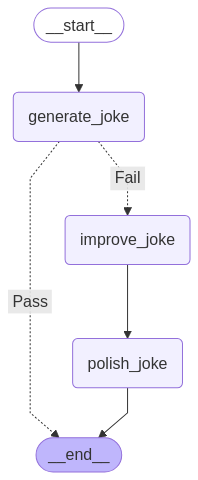

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {'joke': msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}    
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [14]:
# Invoke
state = chain.invoke({"topic": "cats"})

print(f"Initial joke: {state['joke']}")
print("\n--- --- ---\n")
if "improved_joke" in state:
    print(f"Improved joke: {state['improved_joke']}")
    print("\n--- --- ---\n")
    print(f"Final joke: {state['final_joke']}")
else:
    print("Joke failed quality gate - no punchline detected!")


Initial joke: Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 

--- --- ---

Improved joke: Okay, let's amp up the wordplay! Here are a few options, playing on different aspects of the cat and Red Cross:

**Option 1 (Focus on "Aid"):**

Why did the cat join the Red Cross?

Because he wanted to give a paw-sitive contribution to first-aid!
**(Playing on "positive" and "paw")**

**Option 2 (Focus on "Cross"):**

Why did the cat join the Red Cross?

He heard they were looking for a purr-fessional to cross paths with those in need!
**(Playing on "professional" and "purr" and the literal "cross" in Red Cross)**

**Option 3 (Slightly More Absurd):**

Why did the cat join the Red Cross?

He heard they were looking for someone to purr-form emergency CAT scans!
**(Playing on "perform", "purr", and CAT scan)**

**Option 4 (A bit darker, but humorous):**

Why did the cat join the Red Cross?

He wanted to be a CAT-astrophe relief specialist!
**(Playing on "catastrophe

## Parallelization ##

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, **parallelization**, manifests in two key variations: 

* **Sectioning**: Breaking a task into independent subtasks run in parallel. 
* **Voting**: Running the same task multiple times to get diverse outputs.

`When to use this workflow`: **Parallelization** is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

![parallelization](parallelization.png)

In [15]:
# Graph State
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """Second LLM call to generate initial story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate initial poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


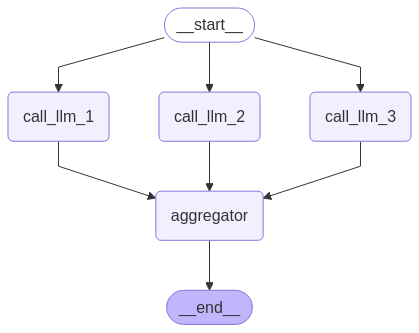

In [17]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [18]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})

print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
The alley behind Mrs. Higgins' bakery was a kingdom ruled by whiskers and claws. Its sovereign was a ginger tabby named Marmalade, a feline Napoleon with a permanent squint and a voice like gravel. He wasn't the biggest, but he was the smartest, and everyone knew it.

His court consisted of a motley crew. There was Luna, a sleek black cat who could scale the brick walls with the grace of a shadow, her eyes like twin emeralds. Patches, a nervous calico, was the gossip, always privy to the neighborhood's secrets whispered through open windows. And then there was Whiskers, a fluffy white Persian who was more interested in beauty naps than politics, but whose presence added a certain air of elegance to the proceedings.

Life in the alley was a constant negotiation. Scraps of discarded croissants, territorial disputes with the neighborhood dogs, the eternal quest for the sunniest spot on the discarded cardboard boxes – all required careful 

## Routing ##

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

`When to use this workflow`: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

![Routing](routing.png)

In [19]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
    

/Users/1004506/Work/code/langgraph_guide/.venv/lib/python3.12/site-packages/pyppeteer/util.py:29: RuntimeWarning: coroutine '_render_mermaid_using_pyppeteer' was never awaited
  gc.collect()
[INFO] Starting Chromium download.
100%|██████████| 141M/141M [00:04<00:00, 28.4Mb/s] 
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/1004506/Library/Application Support/pyppeteer/local-chromium/1181205


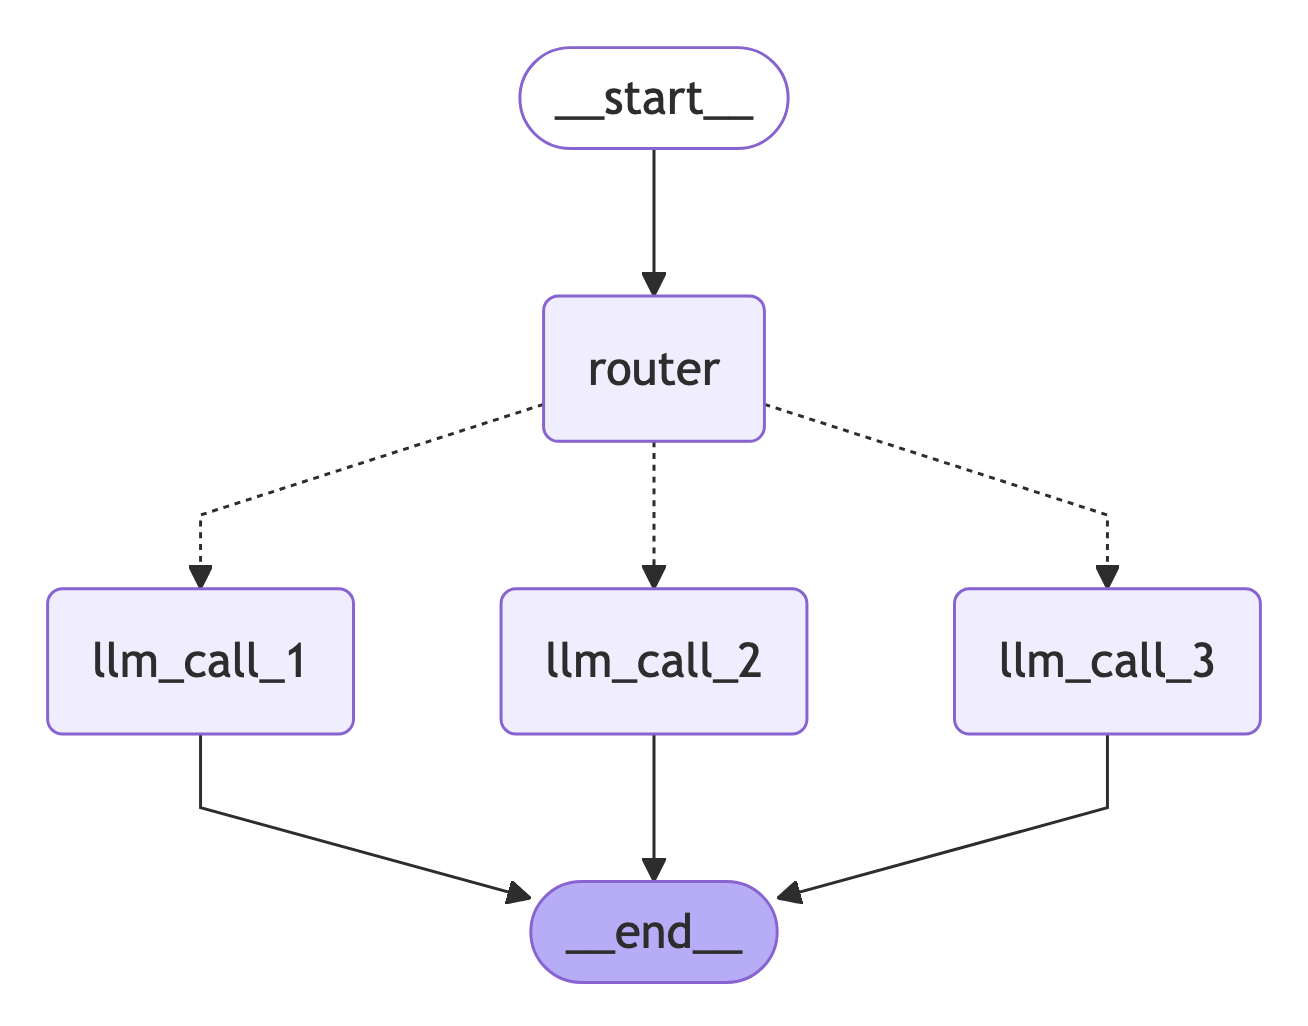

In [33]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("router", llm_call_router)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

# Add edges to connect nodes
router_builder.set_entry_point("router")

# Add conditional edges from the router to the appropriate LLM call node
router_builder.add_conditional_edges(
    "router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)

# Add edges from each LLM call node to the end
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# 워크플로우 컴파일
router_graph = router_builder.compile()

import nest_asyncio
nest_asyncio.apply()

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
display(Image(router_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [34]:
# Invoke
state = router_graph.invoke({"input": "Write me a joke about cats"})

In [35]:
print(state["output"])

Why did the cat join the Red Cross?

Because he wanted to be a first-aid kit!
